Basic Curved trajectory analysis
================================

The objective of this notebook is to learn how to perform linear (curve) trajectory inference from single cell data, starting from a count matrix. Features that significantly changes along the tree will then be extracted and clustered.

## Importing modules and basic settings

In [1]:
import scanpy as sc
import scFates as scf
import warnings
warnings.filterwarnings("ignore")

adata = sc.read('hgForebrainGlut.loom', backup_url='http://pklab.med.harvard.edu/velocyto/hgForebrainGlut/hgForebrainGlut.loom')
adata.var_names_make_unique()
sc.set_figure_params()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [2]:
import sys
sc.settings.verbosity = 3
sc.settings.logfile = sys.stdout

## Pre-processing

In [3]:
sc.pp.filter_genes(adata,min_cells=3)
sc.pp.normalize_total(adata)
sc.pp.log1p(adata,base=10)
sc.pp.highly_variable_genes(adata)

filtered out 18081 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [4]:
adata.raw=adata

In [5]:
adata=adata[:,adata.var.highly_variable]
sc.pp.scale(adata)
sc.pp.pca(adata)

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


... storing 'Chromosome' as categorical
... storing 'Strand' as categorical


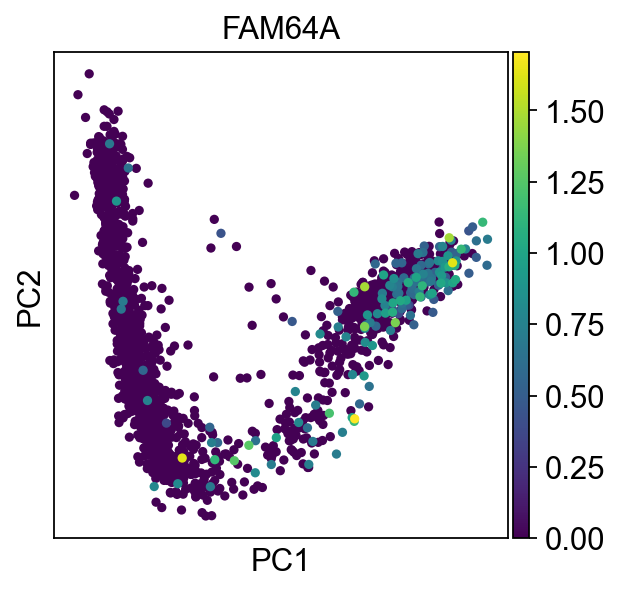

In [6]:
sc.pl.pca(adata,color="FAM64A")

## Learn curve using ElPiGraph algorithm

We will infer a principal curve on the 2 first PC components. Any dimensionality reduction in `.obsm` can be selected using `use_rep` parameter, and the number of dimension to retain can be set using `ndims_rep`.

In [7]:
scf.tl.curve(adata,Nodes=30,use_rep="X_pca",ndims_rep=2,)

inferring a principal curve --> parameters used 
    30 principal points, mu = 0.1, lambda = 0.01
    finished (0:00:00) --> added 
    .uns['epg'] dictionnary containing inferred elastic curve generated from elpigraph.
    .obsm['X_R'] hard assignment of cells to principal points.
    .uns['graph']['B'] adjacency matrix of the principal points.
    .uns['graph']['F'], coordinates of principal points in representation space.


## Projecting the tree on the tsne computed from Palantir

By default the plot function will annotate automatically the tips and the forks ids.

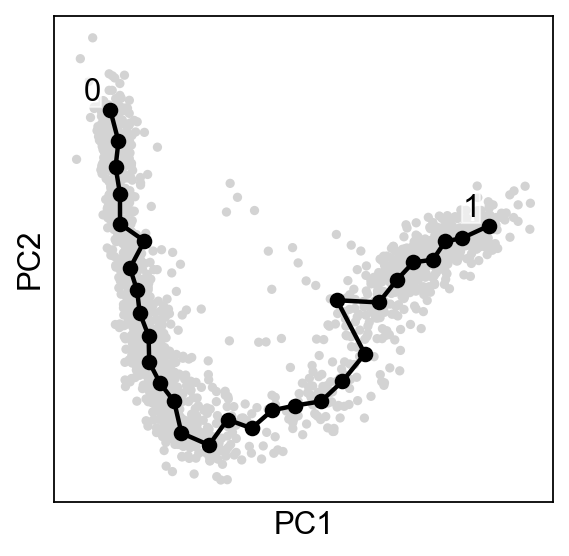

In [8]:
scf.pl.graph(adata,basis="pca")

## Selecting a root and computing pseudotime

Using FAM64A marker, we can confidently tell that the tip 3 is the root.

In [9]:
scf.tl.root(adata,"FAM64A")

automatic root selection using FAM64A values
node 1 selected as a root --> added
    .uns['graph']['root'] selected root.
    .uns['graph']['pp_info'] for each PP, its distance vs root and segment assignment.
    .uns['graph']['pp_seg'] segments network information.


In [10]:
scf.tl.pseudotime(adata)

projecting cells onto the principal graph
    finished (0:00:00) --> added
    .obs['edge'] assigned edge.
    .obs['t'] pseudotime value.
    .obs['seg'] segment of the tree assigned.
    .obs['milestones'] milestone assigned.
    .uns['pseudotime_list'] list of cell projection from all mappings.


In [11]:
adata=adata.raw.to_adata()

## Linearity deviation assessment

In order to verify that the trajectory we are seeing is not the result of a lienar mixture of two population (caused by doublets), we perform the following test:

Estimation of deviation from linearity
    cells on the bridge: 100%|██████████| 1032/1032 [00:05<00:00, 185.67it/s]


... storing '1->0_lindev_sel' as categorical
... storing 'Chromosome' as categorical
... storing 'Strand' as categorical


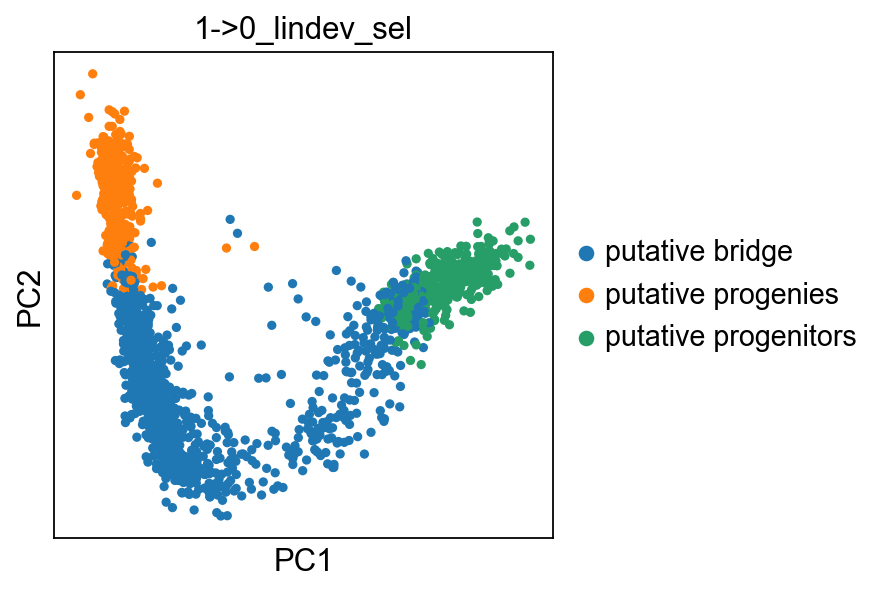

    finished (0:00:07) --> added 
    .var['1->0_rss'], pearson residuals of the linear fit.
    .obs['1->0_lindev_sel'], cell selections used for the test.


In [12]:
scf.tl.linearity_deviation(adata,start_milestone="1",end_milestone="0",n_jobs=20,plot=True,basis="pca")

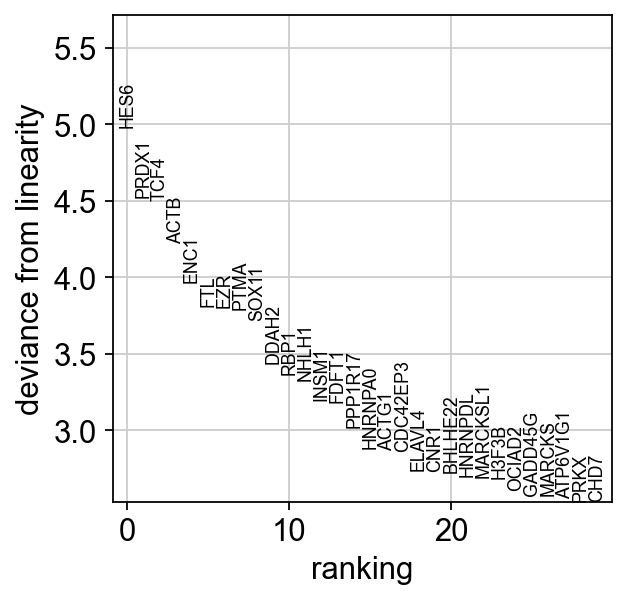

In [13]:
scf.pl.linearity_deviation(adata,start_milestone="1",end_milestone="0")

We have markers that higly deviate from lienarity, and are biologically relevant, we can confidently say that this is a developmental bridge.

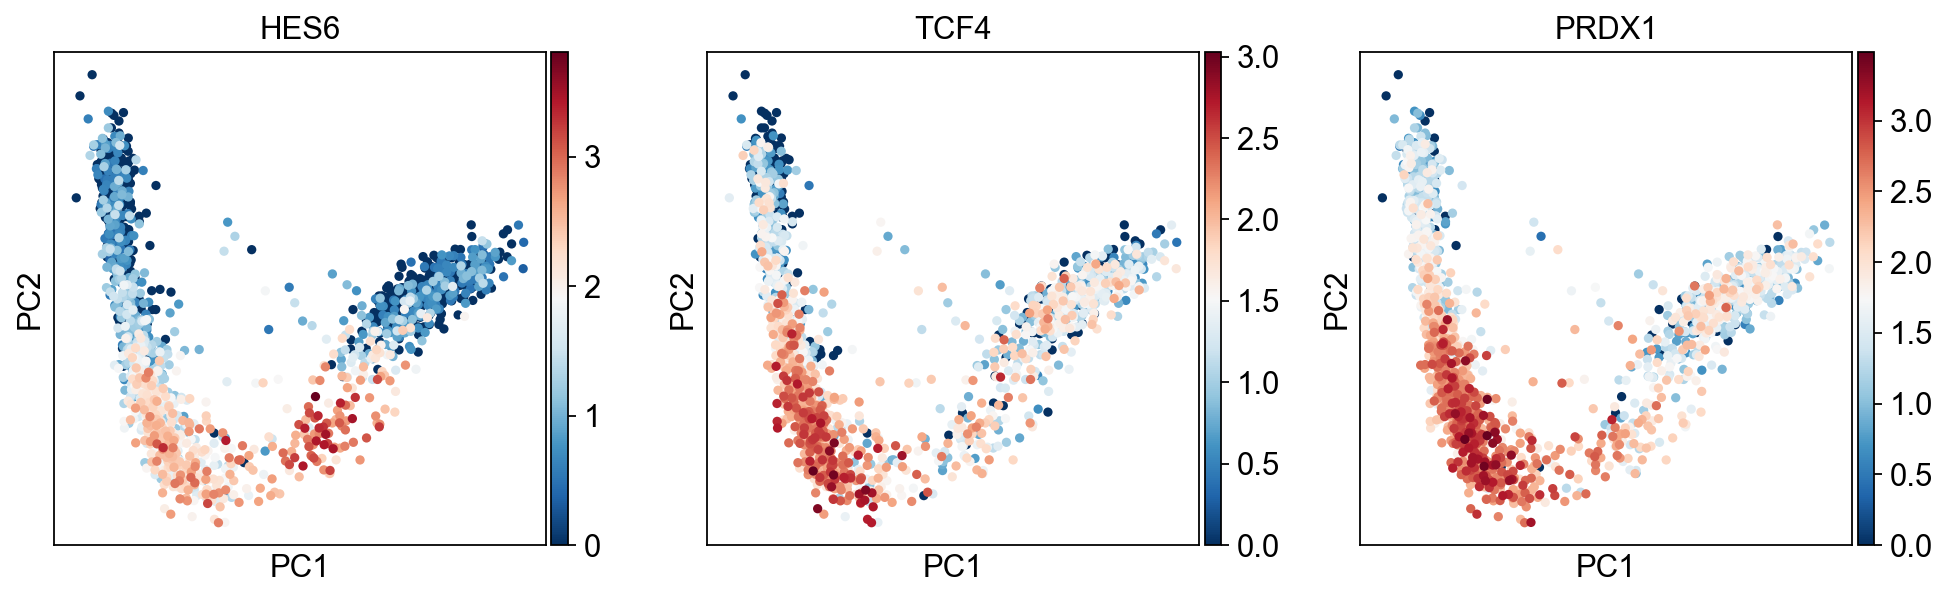

In [14]:
sc.pl.pca(adata,color=["HES6","TCF4","PRDX1"],cmap="RdBu_r")

## Significantly changing feature along pseudotime test

In [15]:
scf.tl.test_association(adata,n_jobs=20)

test features for association with the trajectory
    single mapping : 100%|██████████| 14657/14657 [04:36<00:00, 52.99it/s]
    found 144 significant features (0:04:36) --> added
    .var['p_val'] values from statistical test.
    .var['fdr'] corrected values from multiple testing.
    .var['st'] proportion of mapping in which feature is significant.
    .var['A'] amplitue of change of tested feature.
    .var['signi'] feature is significantly changing along pseudotime.
    .uns['stat_assoc_list'] list of fitted features on the graph for all mappings.


We can change the amplitude parameter to get more significant genes, this can be done without redoing all the tests (`reapply_filters` parameter)

reapplied filters, 617 significant features


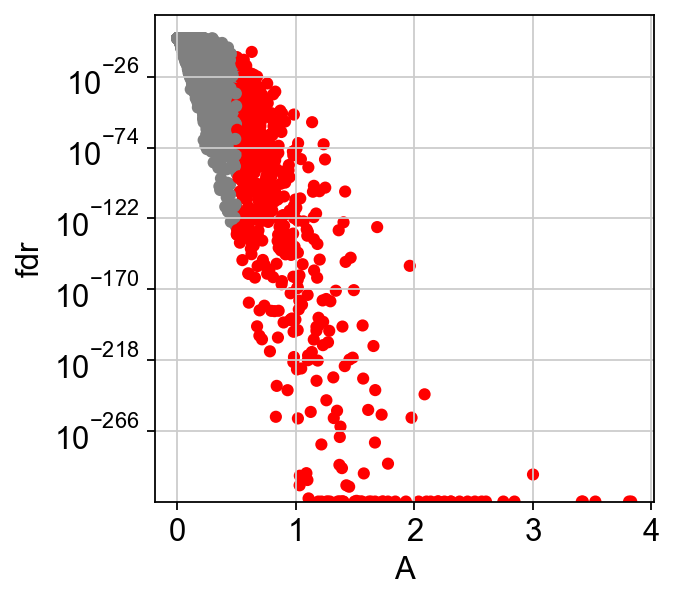

In [16]:
scf.tl.test_association(adata,reapply_filters=True,A_cut=.5)
scf.pl.test_association(adata)

## Fitting & clustering significant features

<div class="alert alert-warning">
    
**Warning**

anndata format can currently only keep the same dimensions for each of its layers. This means that adding the layer for fitted features will lead to dataset subsetted to only those! 

By default the function fit will keep the whole dataset under **adata.raw** (parameter save_raw)

</div>

In [17]:
scf.tl.fit(adata,n_jobs=20)

fit features associated with the trajectory
    single mapping : 100%|██████████| 617/617 [00:16<00:00, 37.84it/s]
    finished (adata subsetted to keep only fitted features!) (0:00:16) --> added
    .layers['fitted'], fitted features on the trajectory for all mappings.
    .raw, unfiltered data.


In [18]:
scf.tl.cluster(adata,knn=100,metric="correlation")

    clustering using phenograph
Finding 100 nearest neighbors using correlation metric and 'brute' algorithm
Neighbors computed in 0.16859769821166992 seconds
Jaccard graph constructed in 1.3103880882263184 seconds
Wrote graph to binary file in 0.046572208404541016 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.586065
After 2 runs, maximum modularity is Q = 0.589688
Louvain completed 22 runs in 1.7968800067901611 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 6.068116188049316 seconds
    finished (0:00:06) --> added
    .obsp['similarity'], pairwise similarity graph.
    .var['fit_clusters'], cluster assignments for features.
    .uns['fit_clusters'], parameters and modularity of the clustering.


In [19]:
adata.var.fit_clusters.unique()

array([0, 3, 2, 1, 4])

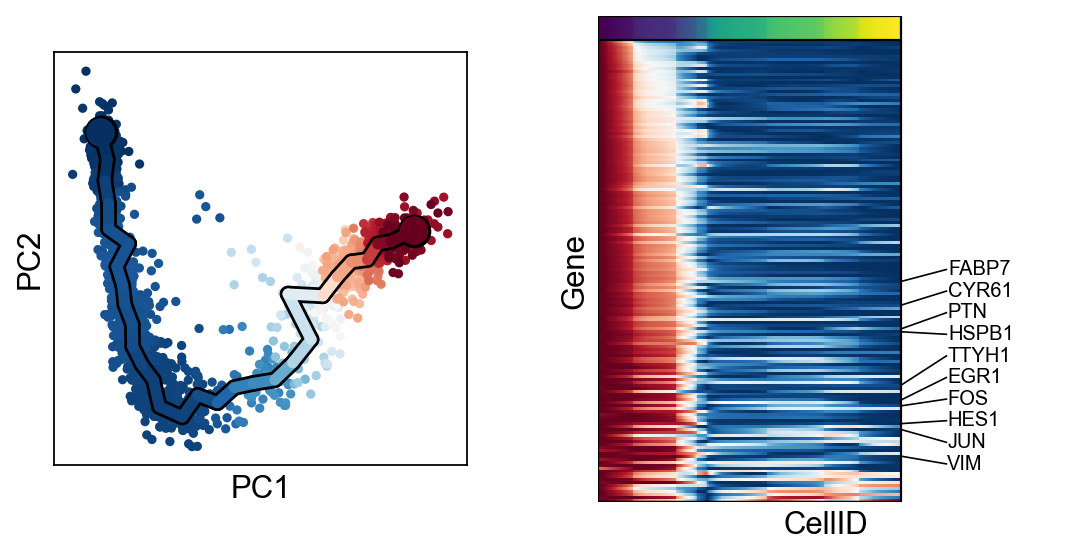

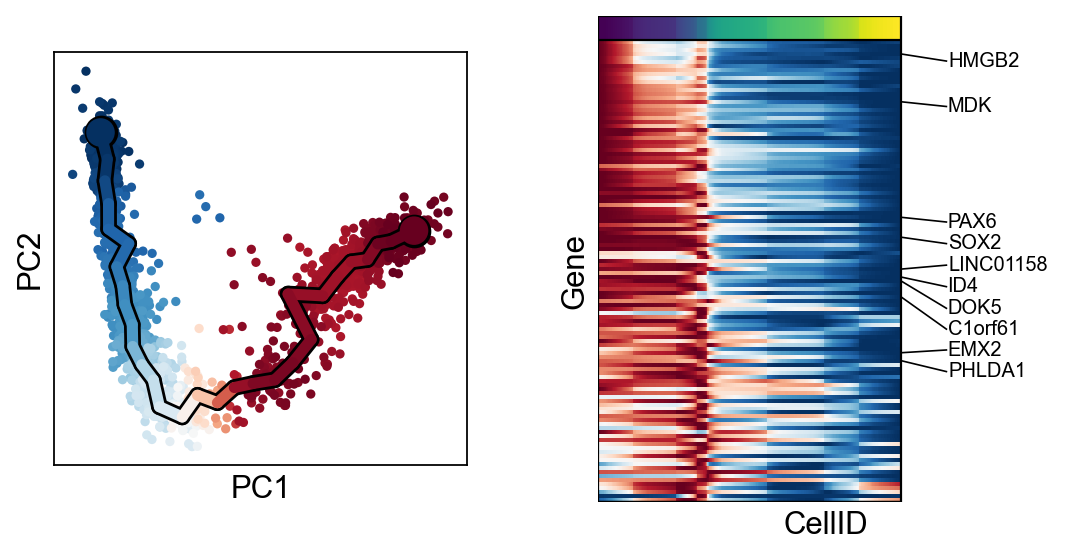

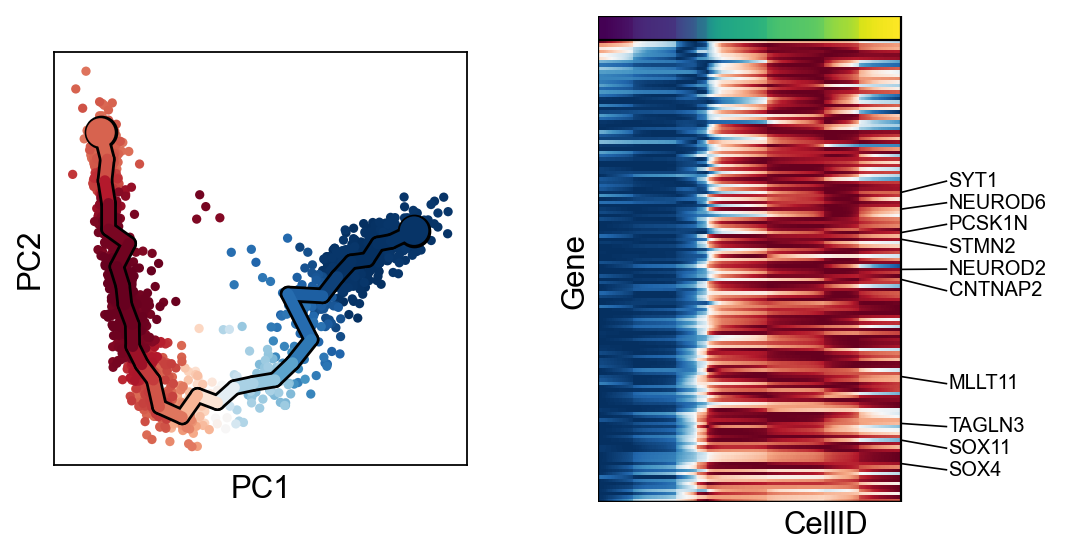

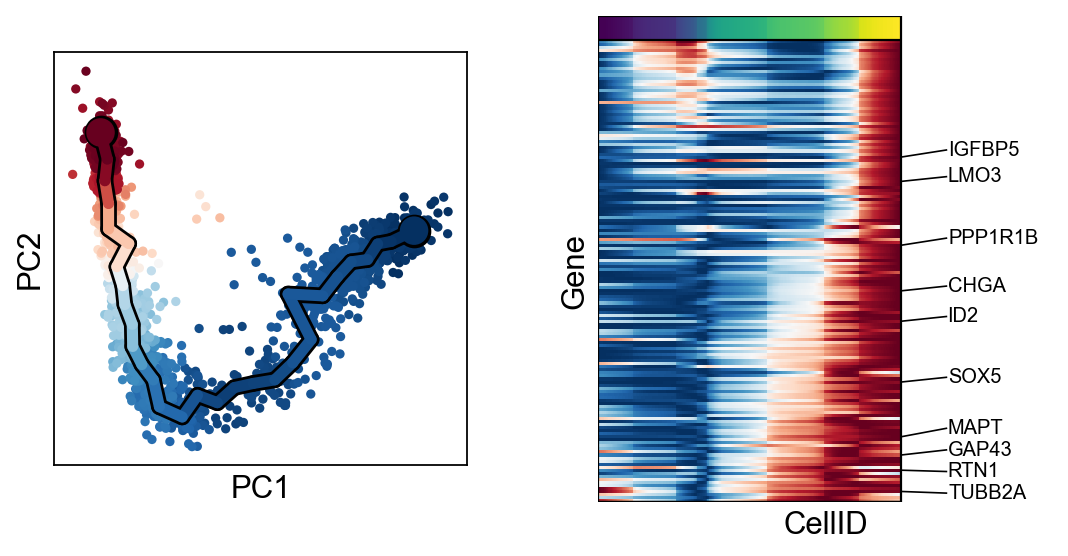

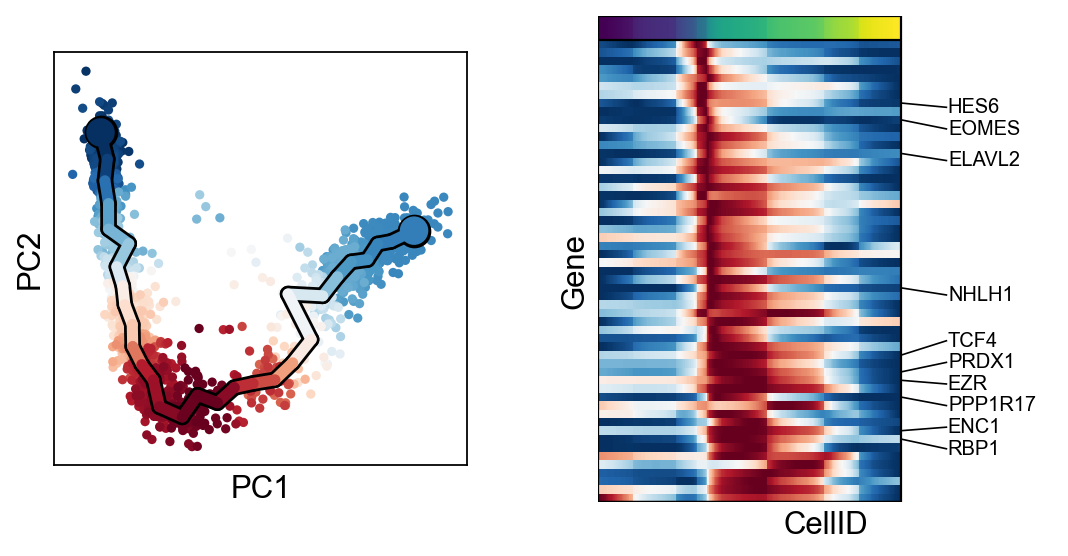

In [20]:
for c in adata.var["fit_clusters"].unique():
    scf.pl.trends(adata,features=adata.var_names[adata.var.fit_clusters==c],basis="pca")